### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Lecture 3

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## MNIST
The MNIST dataset consists of 70000 28x28 garyscale images split into 10 classes. There are 60000 training images and 10000 test images.

### Load data

In [ ]:
# Load MNIST dataset and split into training-validation and test sets
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.mnist.load_data()

# Define a mapping of labels to their corresponding digit names
labels = {0:'Zero', 1:'One', 2:'Two', 3:'Three', 4:'Four', 5:'Five', 6:'Six', 7:'Seven', 8:'Eight', 9:'Nine'}

11490434/11490434 [==============================] - 1s 0us/step


### Inspect data

In [ ]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (60000, 28, 28)
Training-Validation Label Shape: (60000,)
Test Data Shape: (10000, 28, 28)
Test Label Shape: (10000,)


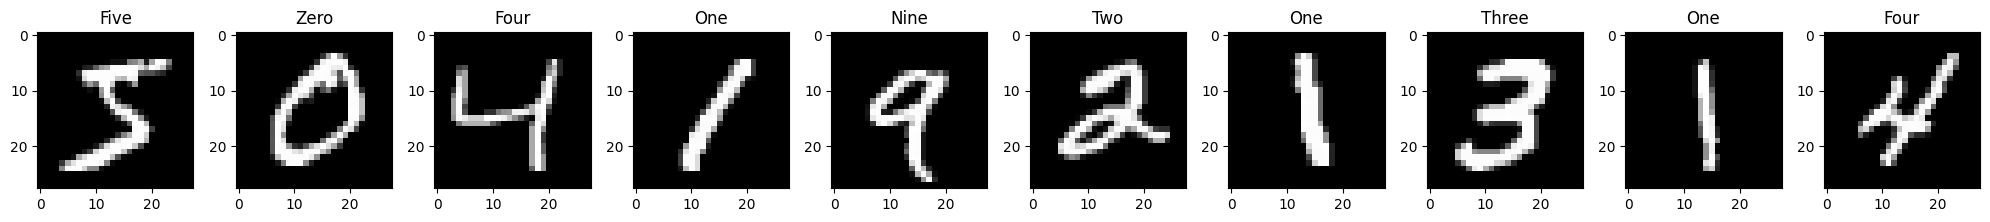

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(X_train_val[i], cmap='gray')
    ax.set_title(f'{labels[y_train_val[i]]}')  # Show the corresponding digit label

# Adjust layout and display the images
plt.tight_layout()
plt.show()

### Process data

In [ ]:
# Add the grayscale channel to the images moving from (x, 28, 28) to (x, 28, 28, 1), with x cardinality
X_train_val = np.expand_dims(X_train_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Print the shapes of the padded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Test Data Shape:", X_test.shape)

Training-Validation Data Shape: (60000, 28, 28, 1)
Test Data Shape: (10000, 28, 28, 1)


In [ ]:
# Expand also the labels dimension moving from (x,) to (x, 1), with x cardinality
y_train_val = np.expand_dims(y_train_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (60000, 28, 28, 1)
Training-Validation Label Shape: (60000, 1)
Test Data Shape: (10000, 28, 28, 1)
Test Label Shape: (10000, 1)


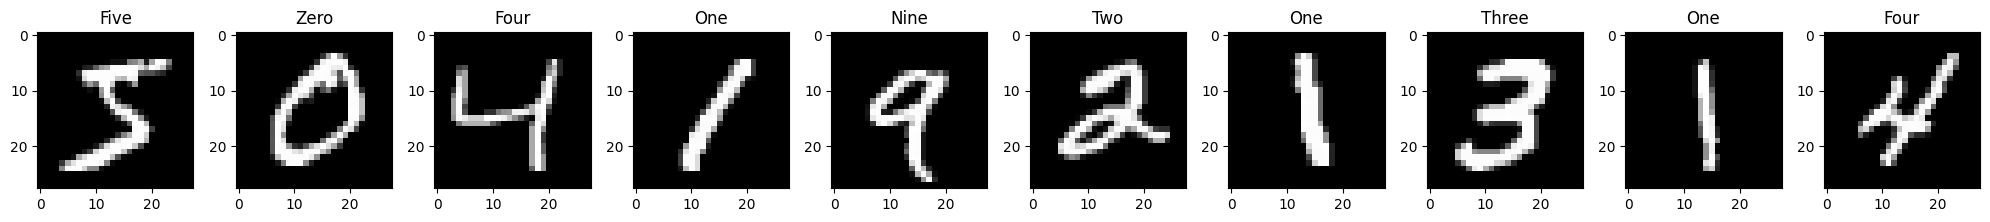

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(X_train_val[i], cmap='gray')
    ax.set_title(f'{labels[y_train_val[i][0]]}')  # Show the corresponding digit label

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: digit, dtype: int64


In [ ]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (54000, 28, 28, 1)
Training Label Shape: (54000, 10)
Validation Data Shape: (6000, 28, 28, 1)
Validation Label Shape: (6000, 10)


In [ ]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Categorical label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
"Default" label: 2


In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 128                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 128
Input Shape: (28, 28, 1)
Output Shape: 10


### Convolutional Neural Networks ingredients

Simple convolution (spatial dimension is reduced!)


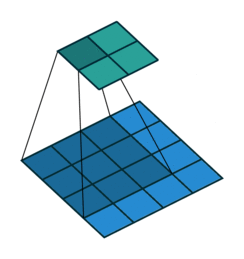

Convolution with (same) padding

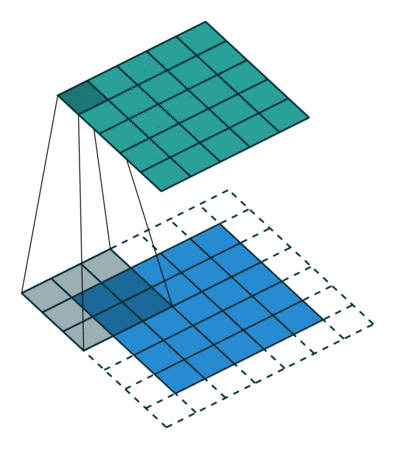

Pooling (max and average)

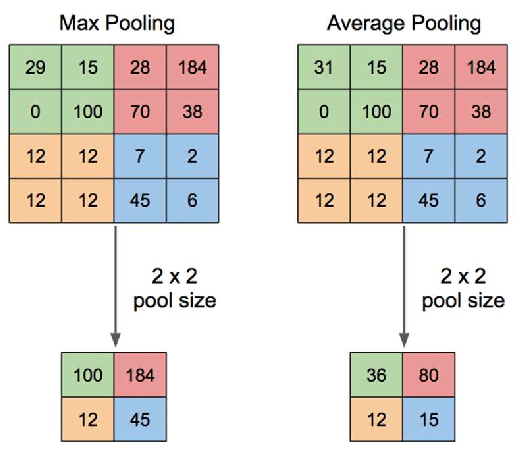

### Build the model (LeNet)

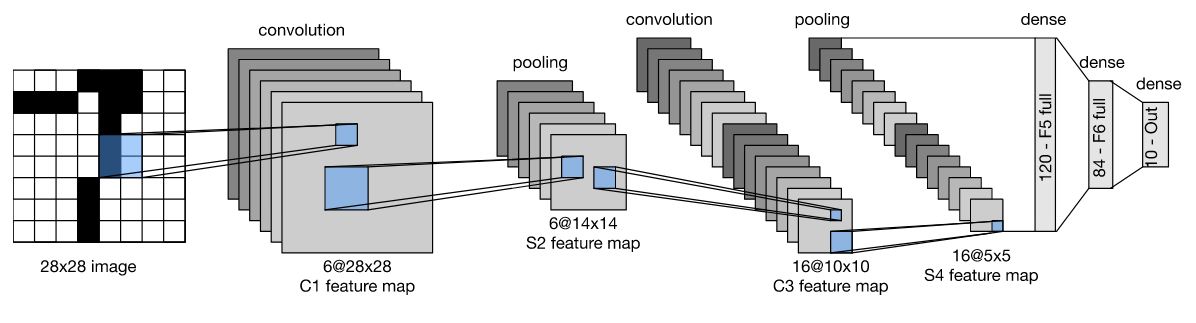

In [ ]:
def build_LeNet(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=6,
        kernel_size=(5,5),
        padding='same',
        activation='tanh',
        name='conv1'
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp1'
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(5,5),
        padding='valid',
        activation='tanh',
        name='conv2'
    )(pool1)

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp2'
    )(conv2)

    flattening_layer=tfkl.Flatten(
        name='flatten'
    )(pool2)

    classifier_layer=tfkl.Dense(
        units=120,
        activation='tanh',
        name='dense1'
    )(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=84,
        activation='tanh',
        name='dense2'
    )(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='LeNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
# Build the LeNet model and display its summary
model = build_LeNet(input_shape, output_shape)
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 6)         156       
                                                                 
 mp1 (MaxPooling2D)          (None, 14, 14, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 10, 10, 16)        2416      
                                                                 
 mp2 (MaxPooling2D)          (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense1 (Dense)              (None, 120)               48120 

### Train the model

In [ ]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('LeNet_MNIST')

Epoch 1/200
422/422 [==============================] - 14s 7ms/step - loss: 0.2624 - accuracy: 0.9271 - val_loss: 0.0911 - val_accuracy: 0.9740
Epoch 2/200
422/422 [==============================] - 2s 5ms/step - loss: 0.0687 - accuracy: 0.9793 - val_loss: 0.0653 - val_accuracy: 0.9785
Epoch 3/200
422/422 [==============================] - 2s 5ms/step - loss: 0.0478 - accuracy: 0.9858 - val_loss: 0.0586 - val_accuracy: 0.9840
Epoch 4/200
422/422 [==============================] - 2s 5ms/step - loss: 0.0368 - accuracy: 0.9888 - val_loss: 0.0672 - val_accuracy: 0.9795
Epoch 5/200
422/422 [==============================] - 2s 5ms/step - loss: 0.0294 - accuracy: 0.9908 - val_loss: 0.0510 - val_accuracy: 0.9852
Epoch 6/200
422/422 [==============================] - 3s 6ms/step - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0480 - val_accuracy: 0.9868
Epoch 7/200
422/422 [==============================] - 2s 6ms/step - loss: 0.0176 - accuracy: 0.9953 - val_loss: 0.0525 - val_accuracy: 0.985

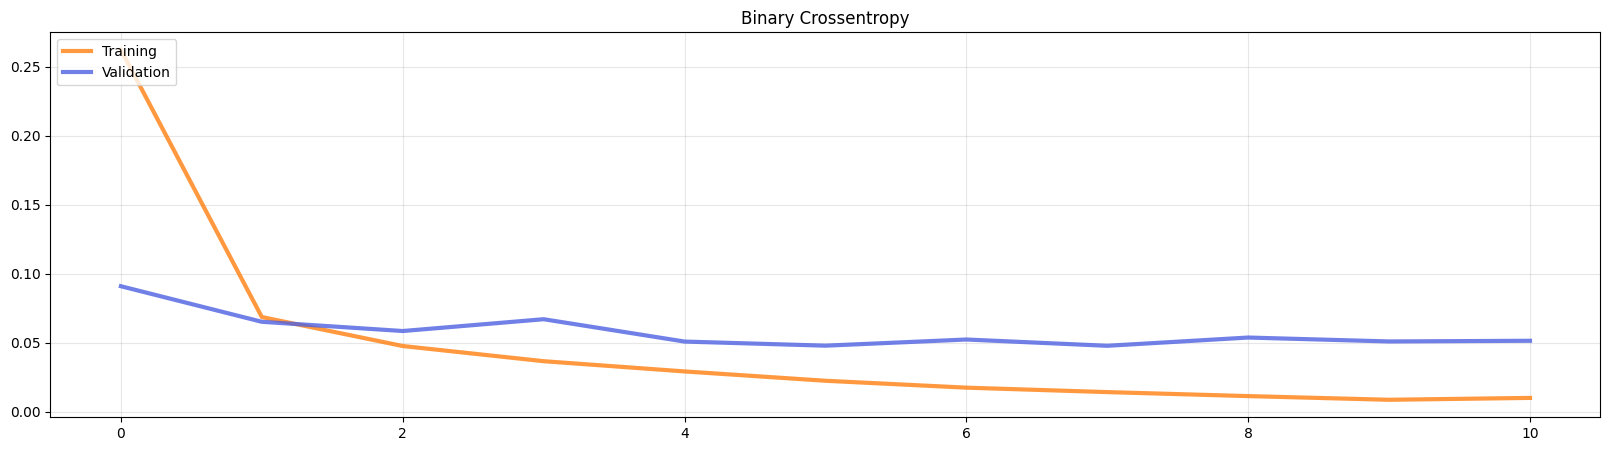

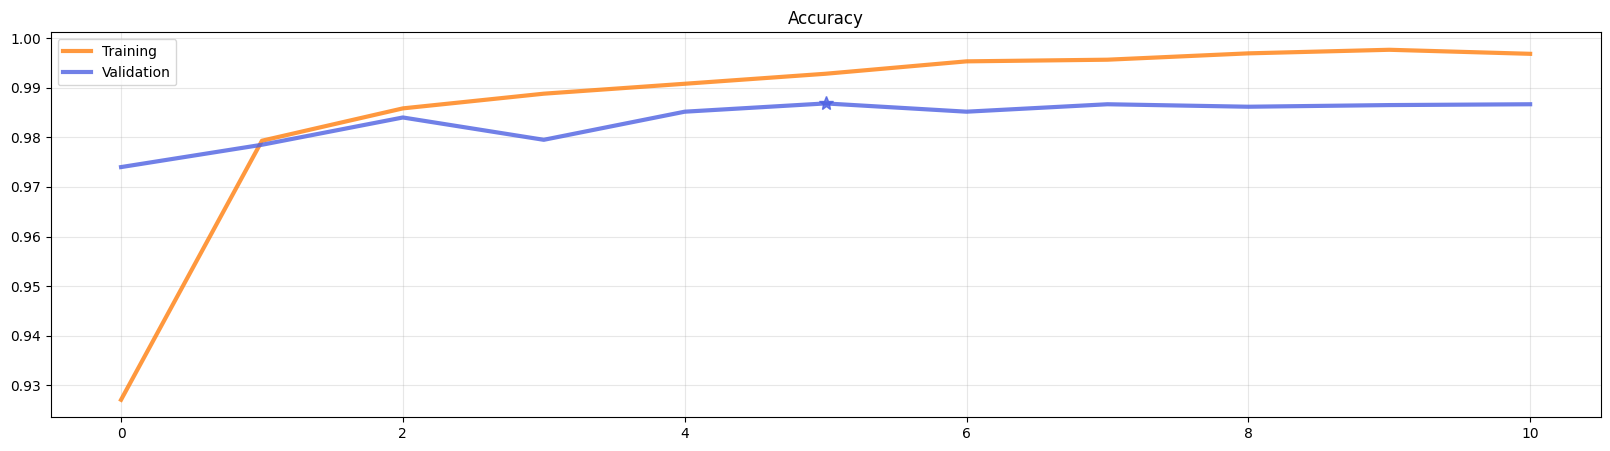

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Delete the model instance to free up memory
del model

#### Inspect LeNet activations

In [ ]:
# Load the saved LeNet model
model = tfk.models.load_model('LeNet_MNIST')

In [ ]:
# Extract activations from the first convolutional layer for a subset of test images
num_images = 100
first_conv = tfk.Sequential(model.layers[:2])
first_activations = first_conv(X_test[0:num_images])

# Extract activations from the second convolutional layer for the same subset of test images
second_conv = tfk.Sequential(model.layers[:4])
second_activations = second_conv(X_test[0:num_images])

Input image


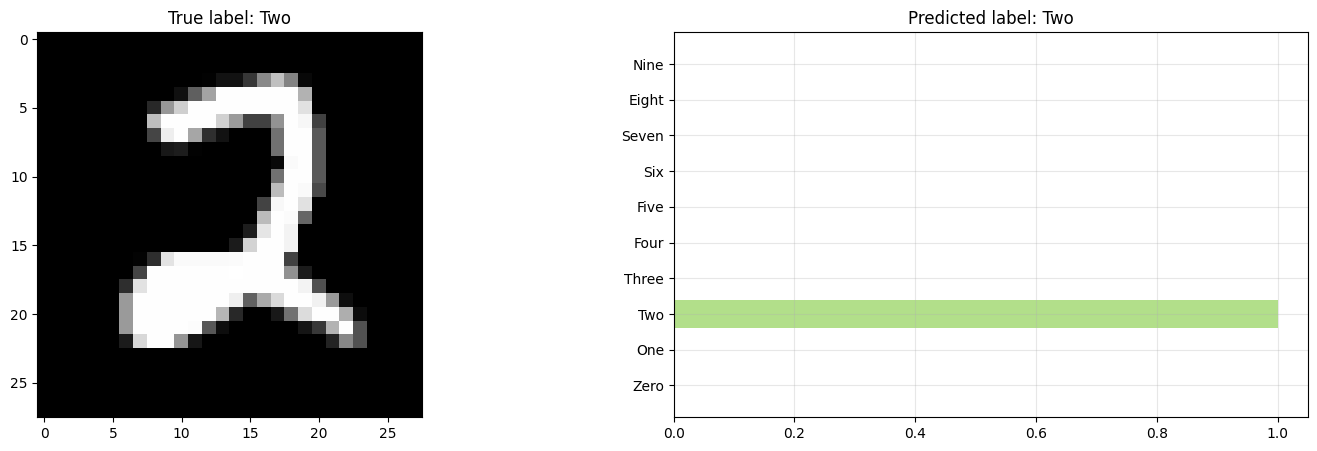

First convolutional activations


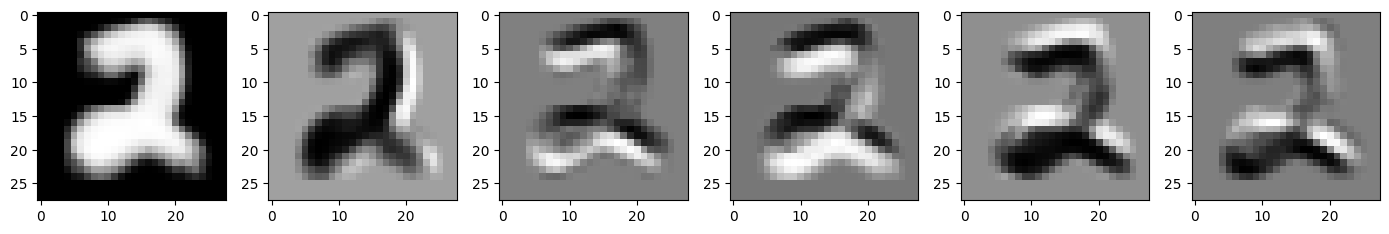

Second convolutional activations


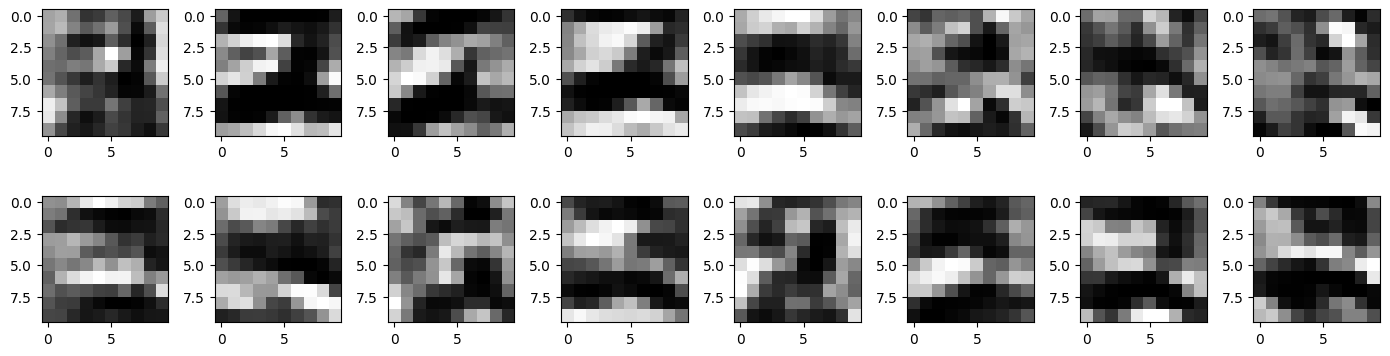

In [ ]:
# Choose a random image for visualization
image = np.random.randint(0, num_images)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow(X_test[image], cmap='gray')
ax1.set_title('True label: ' + labels[np.argmax(y_test[image])])
prediction = model.predict(np.expand_dims(X_test[image], axis=0), verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

# Display activations from the first convolutional layer
print('First convolutional activations')
num_row = 1
num_col = 6
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 12))
for i in range(num_row * num_col):
    ax = axes[i % num_col]
    ax.imshow(first_activations[image, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

# Display activations from the second convolutional layer
print('Second convolutional activations')
num_row = 2
num_col = 8
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 4))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(second_activations[image, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

Input image


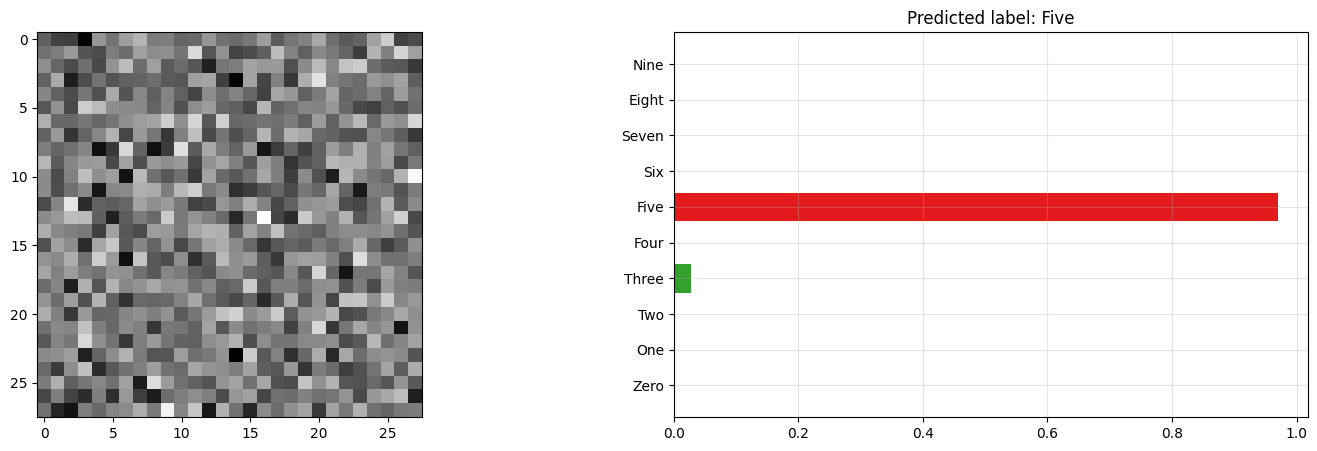

First convolutional activations


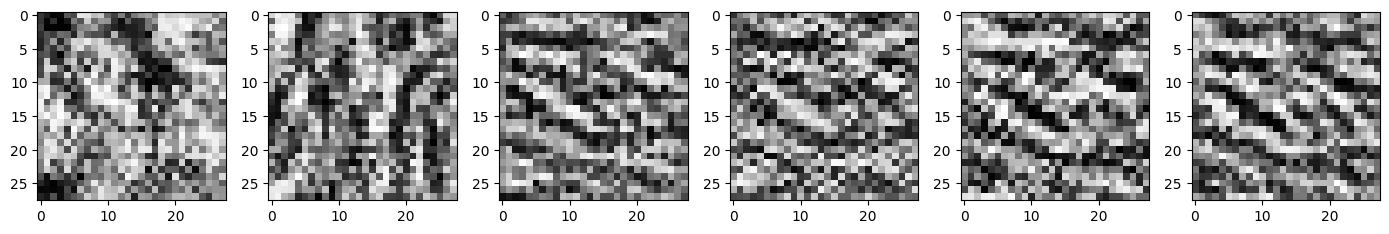

Second convolutional activations


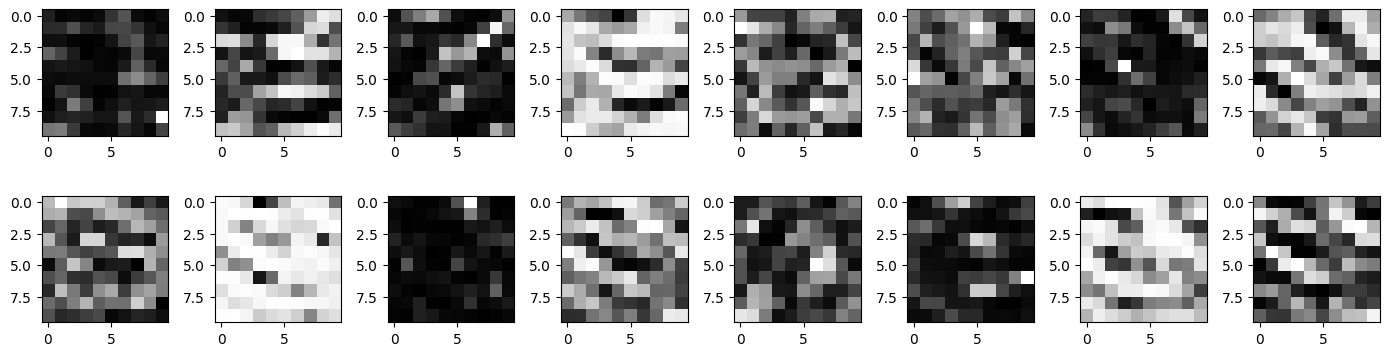

In [ ]:
# Generate normal noise with the same image shape
image = np.random.randn(1,28,28,1)
image.shape

# Extract activations from the first convolutional layer for the noise image
first_conv = tfk.Sequential(model.layers[:2])
first_activations = first_conv(image)

# Extract activations from the second convolutional layer for the noise image
second_conv = tfk.Sequential(model.layers[:4])
second_activations = second_conv(image)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow(np.squeeze(image), cmap='gray')
prediction = model.predict(image, verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

# Display activations from the first convolutional layer
print('First convolutional activations')
num_row = 1
num_col = 6
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 12))
for i in range(num_row * num_col):
    ax = axes[i % num_col]
    ax.imshow(first_activations[0,:,:,i], cmap='gray')
plt.tight_layout()
plt.show()

# Display activations from the second convolutional layer
print('Second convolutional activations')
num_row = 2
num_col = 8
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 4))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(second_activations[0,:,:,i], cmap='gray')
plt.tight_layout()
plt.show()

### Make inference

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (10000, 10)


Accuracy: 0.9899
Precision: 0.9899
Recall: 0.9898
F1: 0.9899


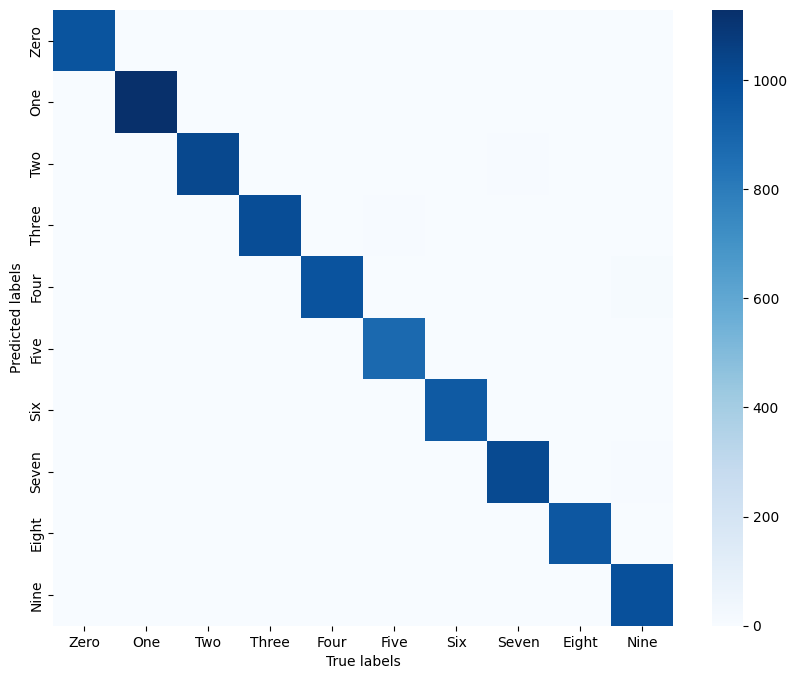

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## CIFAR-10
The CIFAR-10 dataset consists of 60000 32x32 RGB images split into 10 classes. There are 50000 training images and 10000 test images.

### Load data

In [ ]:
# Load CIFAR-10 dataset and split into training-validation and test sets
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.cifar10.load_data()

# Define a mapping of labels to their corresponding class names
labels = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

170498071/170498071 [==============================] - 74s 0us/step


### Inspect data

In [ ]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (50000, 32, 32, 3)
Training-Validation Label Shape: (50000, 1)
Test Data Shape: (10000, 32, 32, 3)
Test Label Shape: (10000, 1)


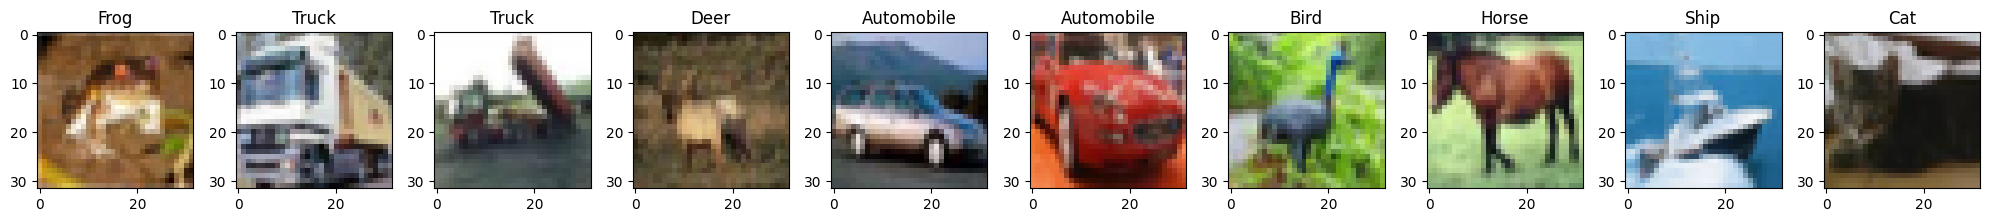

In [ ]:
# Display a sample of images from the training-validation dataset
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(X_train_val[i])
    ax.set_title('{}'.format(labels[y_train_val[i][0]]))

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['class'])['class'].value_counts())

Counting occurrences of target classes:
6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
Name: class, dtype: int64


### Process data

In [ ]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (45000, 32, 32, 3)
Training Label Shape: (45000, 10)
Validation Data Shape: (5000, 32, 32, 3)
Validation Label Shape: (5000, 10)


In [ ]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
"Default" label: 8


In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 128                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 128
Input Shape: (32, 32, 3)
Output Shape: 10


### Build the model

In [ ]:
# Build the LeNet model and display its summary
model = build_LeNet(input_shape, output_shape)
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 6)         456       
                                                                 
 mp1 (MaxPooling2D)          (None, 16, 16, 6)         0         
                                                                 
 conv2 (Conv2D)              (None, 12, 12, 16)        2416      
                                                                 
 mp2 (MaxPooling2D)          (None, 6, 6, 16)          0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense1 (Dense)              (None, 120)               69240 

### Train the model

In [ ]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('LeNet_CIFAR10')

Epoch 1/200
352/352 [==============================] - 5s 9ms/step - loss: 1.6046 - accuracy: 0.4235 - val_loss: 1.4333 - val_accuracy: 0.4924
Epoch 2/200
352/352 [==============================] - 2s 6ms/step - loss: 1.3395 - accuracy: 0.5230 - val_loss: 1.2865 - val_accuracy: 0.5530
Epoch 3/200
352/352 [==============================] - 2s 6ms/step - loss: 1.2292 - accuracy: 0.5673 - val_loss: 1.2276 - val_accuracy: 0.5634
Epoch 4/200
352/352 [==============================] - 2s 6ms/step - loss: 1.1554 - accuracy: 0.5935 - val_loss: 1.1678 - val_accuracy: 0.5866
Epoch 5/200
352/352 [==============================] - 2s 6ms/step - loss: 1.0921 - accuracy: 0.6157 - val_loss: 1.1621 - val_accuracy: 0.5974
Epoch 6/200
352/352 [==============================] - 3s 8ms/step - loss: 1.0347 - accuracy: 0.6373 - val_loss: 1.1030 - val_accuracy: 0.6120
Epoch 7/200
352/352 [==============================] - 3s 7ms/step - loss: 0.9918 - accuracy: 0.6520 - val_loss: 1.1003 - val_accuracy: 0.6184

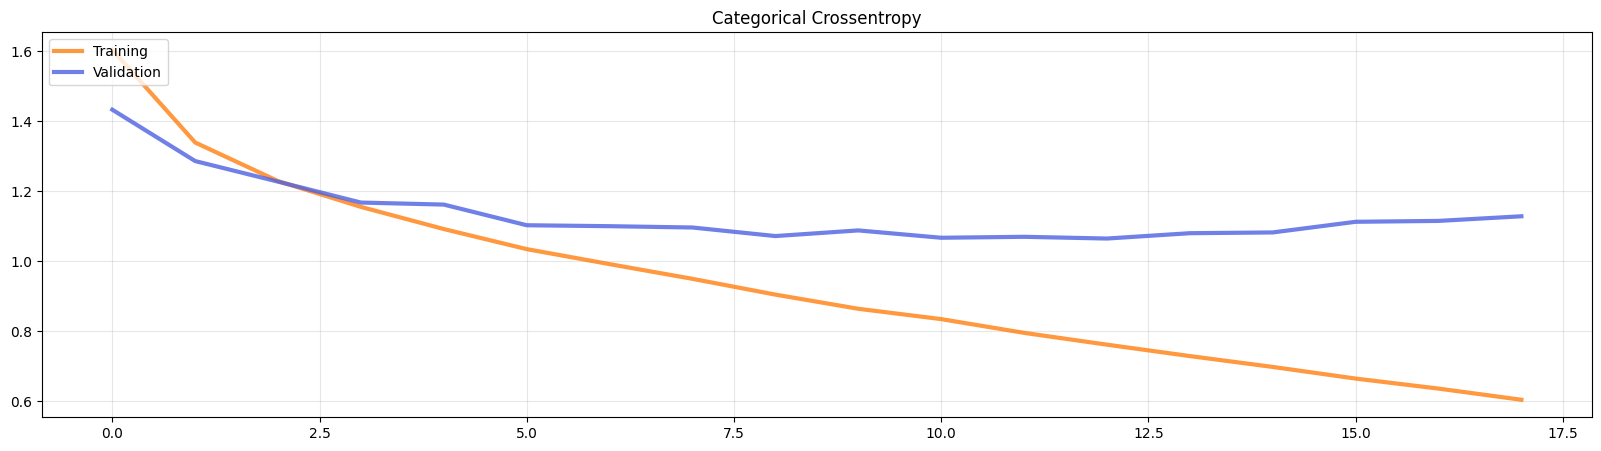

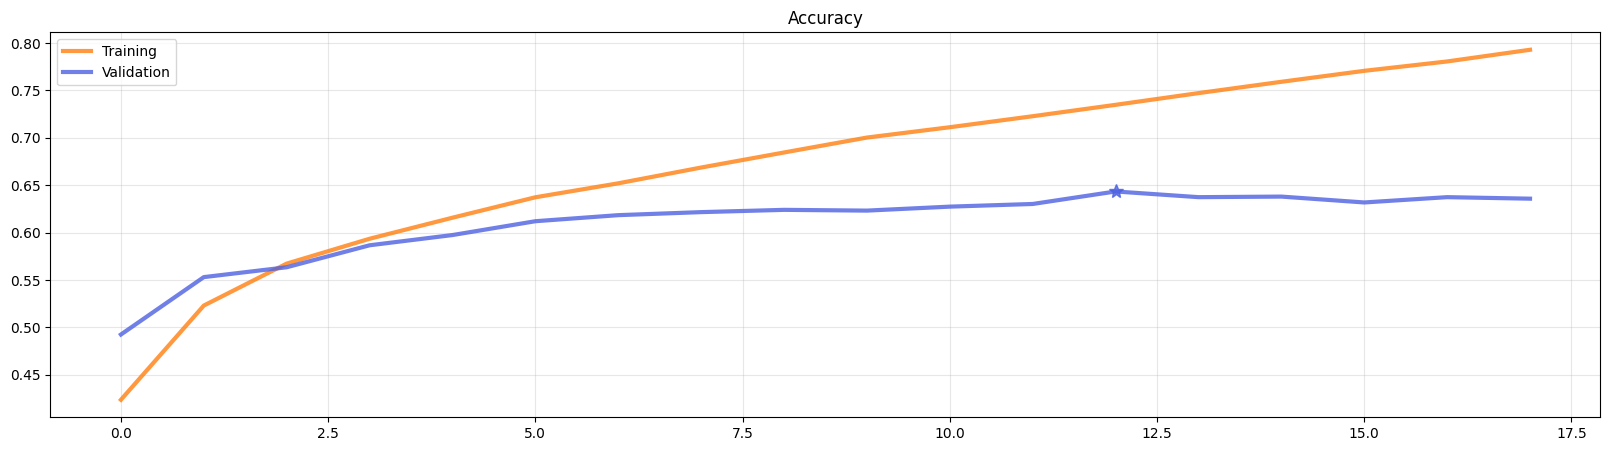

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Delete the model instance to free up memory
del model

#### Inspect LeNet activations

In [ ]:
# Load the saved LeNet model
model = tfk.models.load_model('LeNet_CIFAR10')

In [ ]:
# Extract activations from the first convolutional layer for a subset of test images
num_images = 100
first_conv = tfk.Sequential(model.layers[:2])
first_activations = first_conv(X_test[0:num_images])

# Extract activations from the second convolutional layer for the same subset of test images
second_conv = tfk.Sequential(model.layers[:4])
second_activations = second_conv(X_test[0:num_images])

Input image


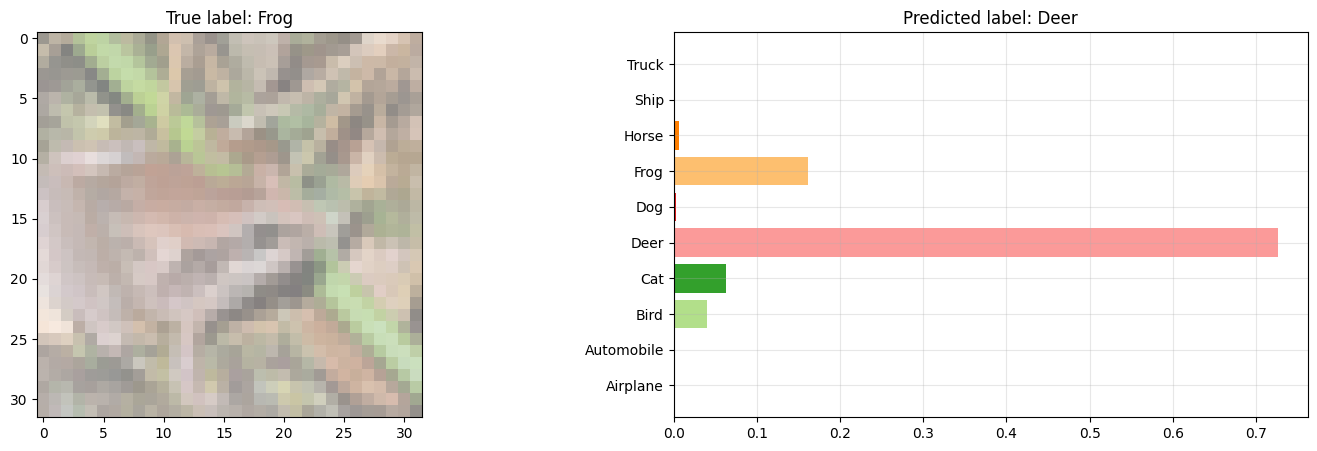

First convolutional activations


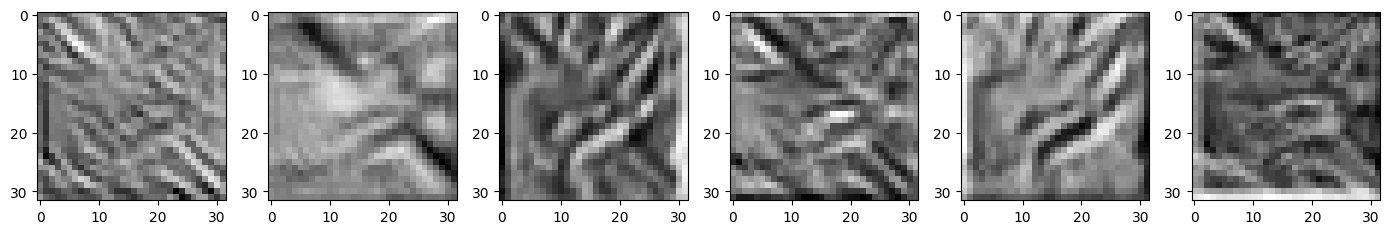

Second convolutional activations


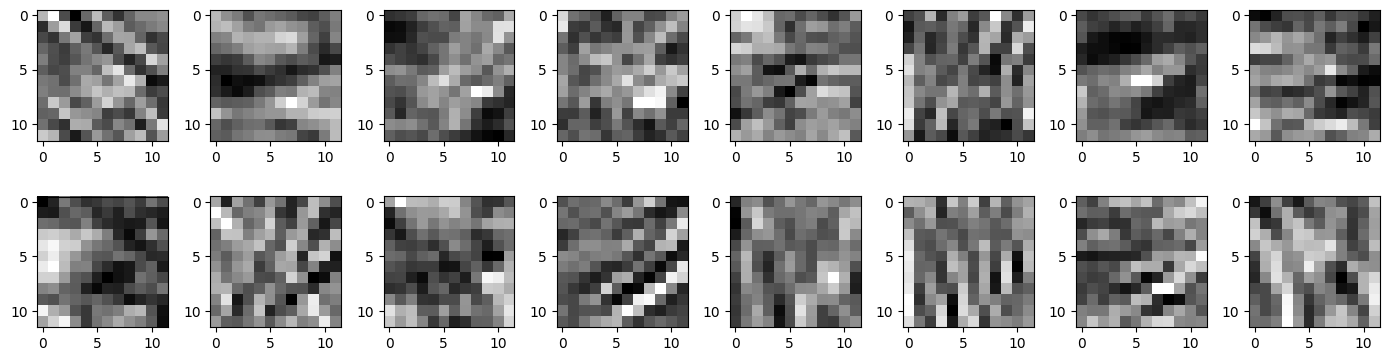

In [ ]:
# Choose a random image for visualization
image = np.random.randint(0, num_images)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow((X_test[image] + 1) / 2)
ax1.set_title('True label: ' + labels[np.argmax(y_test[image])])
prediction = model.predict(np.expand_dims(X_test[image], axis=0), verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

# Display activations from the first convolutional layer
print('First convolutional activations')
num_row = 1
num_col = 6
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 12))
for i in range(num_row * num_col):
    ax = axes[i % num_col]
    ax.imshow(first_activations[image, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

# Display activations from the second convolutional layer
print('Second convolutional activations')
num_row = 2
num_col = 8
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 4))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(second_activations[image, :, :, i], cmap='gray')
plt.tight_layout()
plt.show()

Input image


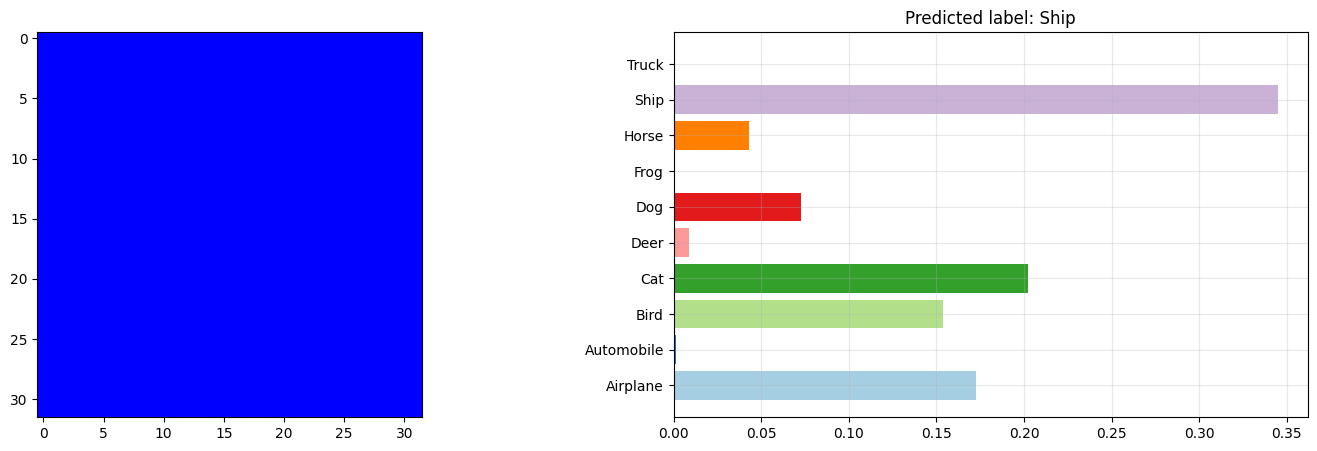

First convolutional activations


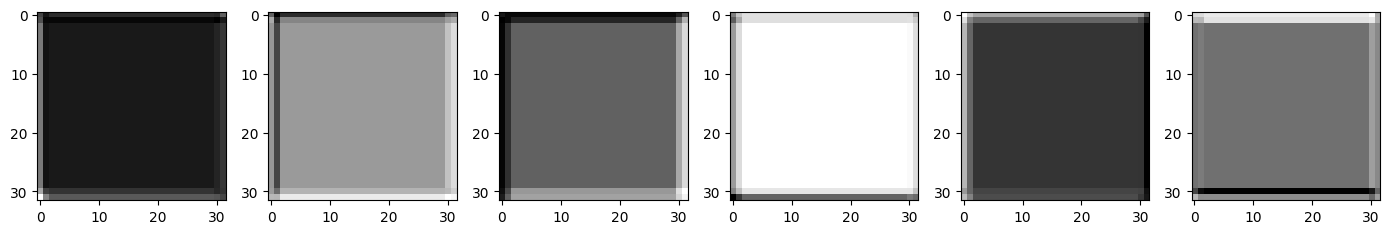

Second convolutional activations


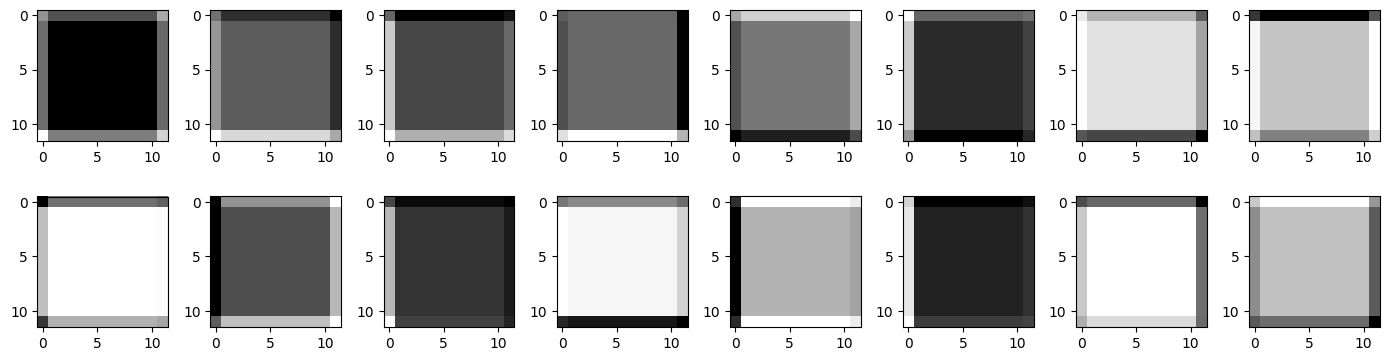

In [ ]:
# Define a blue color image
image = np.concatenate((np.zeros((1,32,32,2)),np.ones((1,32,32,1))),axis=-1)

# Extract activations from the first convolutional layer for the blue color image
first_conv = tfk.Sequential(model.layers[:2])
first_activations = first_conv(image)

# Extract activations from the second convolutional layer for the blue color image
second_conv = tfk.Sequential(model.layers[:4])
second_activations = second_conv(image)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow(np.squeeze(image), cmap='gray')
prediction = model.predict(image, verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

# Display activations from the first convolutional layer
print('First convolutional activations')
num_row = 1
num_col = 6
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 12))
for i in range(num_row * num_col):
    ax = axes[i % num_col]
    ax.imshow(first_activations[0,:,:,i], cmap='gray')
plt.tight_layout()
plt.show()

# Display activations from the second convolutional layer
print('Second convolutional activations')
num_row = 2
num_col = 8
fig, axes = plt.subplots(num_row, num_col, figsize=(14, 4))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(second_activations[0,:,:,i], cmap='gray')
plt.tight_layout()
plt.show()

#### Make Inference

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (10000, 10)


Accuracy: 0.632
Precision: 0.629
Recall: 0.632
F1: 0.6272


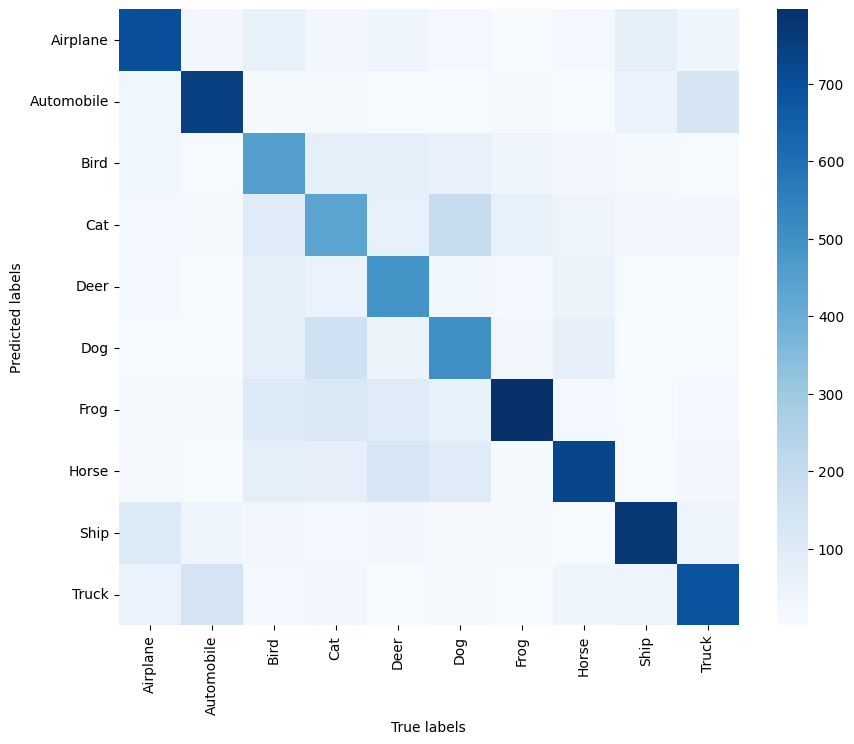

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Build a quasiVGG9 model

In [ ]:
def build_quasiVGG9(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv00')(input_layer)
    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv01')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv10')(x)
    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv11')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv20')(x)
    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv21')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv30')(x)
    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv31')(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=output_shape,activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Convnet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(weight_decay=5e-4), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
# Build the quasiVGG9 model and display its summary
model = build_quasiVGG9(input_shape, output_shape)
model.summary()

Model: "Convnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv00 (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv01 (Conv2D)             (None, 32, 32, 32)        9248      
                                                                 
 mp0 (MaxPooling2D)          (None, 16, 16, 32)        0         
                                                                 
 conv10 (Conv2D)             (None, 16, 16, 64)        18496     
                                                                 
 conv11 (Conv2D)             (None, 16, 16, 64)        36928     
                                                                 
 mp1 (MaxPooling2D)          (None, 8, 8, 64)          0   

### Train the model

In [ ]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('QuasiVGG9_CIFAR10')

Epoch 1/200
352/352 [==============================] - 11s 20ms/step - loss: 1.7381 - accuracy: 0.3376 - val_loss: 1.4528 - val_accuracy: 0.4580
Epoch 2/200
352/352 [==============================] - 5s 15ms/step - loss: 1.2897 - accuracy: 0.5252 - val_loss: 1.1250 - val_accuracy: 0.5842
Epoch 3/200
352/352 [==============================] - 6s 16ms/step - loss: 1.0494 - accuracy: 0.6203 - val_loss: 0.9280 - val_accuracy: 0.6656
Epoch 4/200
352/352 [==============================] - 6s 16ms/step - loss: 0.8710 - accuracy: 0.6873 - val_loss: 0.8500 - val_accuracy: 0.6912
Epoch 5/200
352/352 [==============================] - 6s 16ms/step - loss: 0.7462 - accuracy: 0.7350 - val_loss: 0.7800 - val_accuracy: 0.7324
Epoch 6/200
352/352 [==============================] - 6s 17ms/step - loss: 0.6373 - accuracy: 0.7758 - val_loss: 0.7222 - val_accuracy: 0.7506
Epoch 7/200
352/352 [==============================] - 5s 16ms/step - loss: 0.5557 - accuracy: 0.8051 - val_loss: 0.6853 - val_accuracy

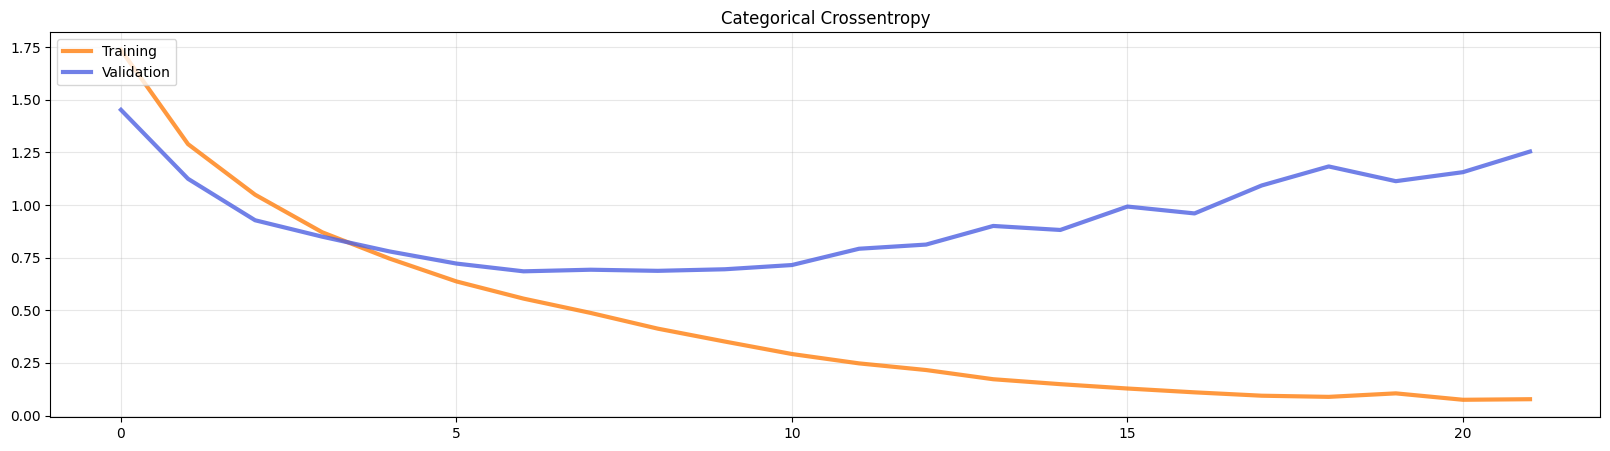

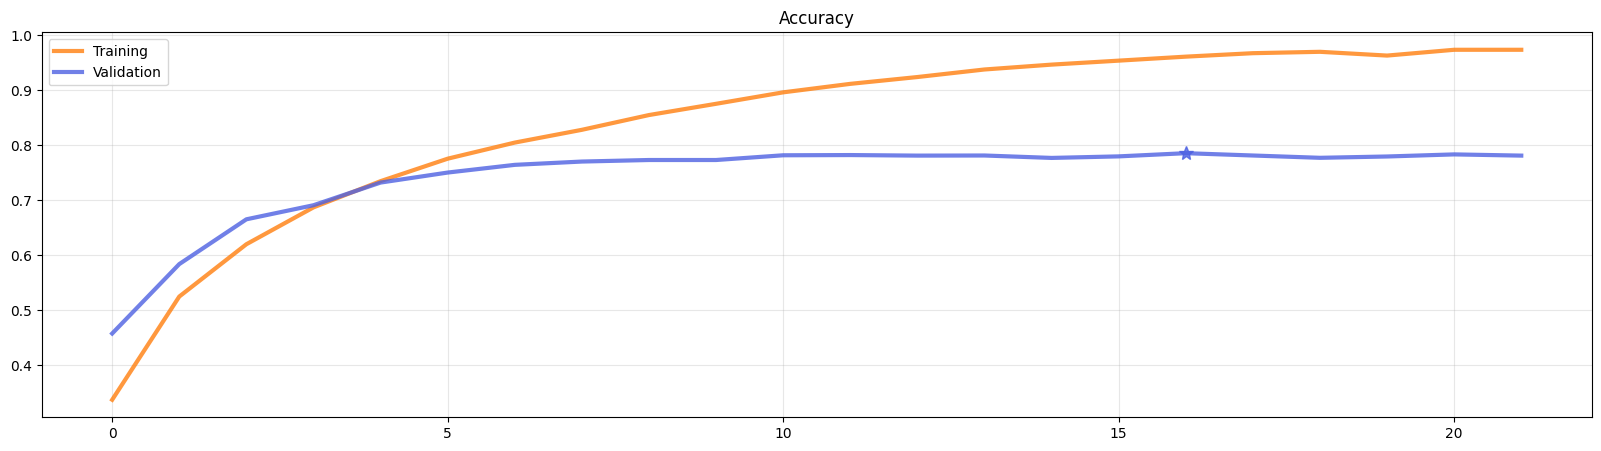

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Delete the model instance to free up memory
del model

#### Make inference

Input image


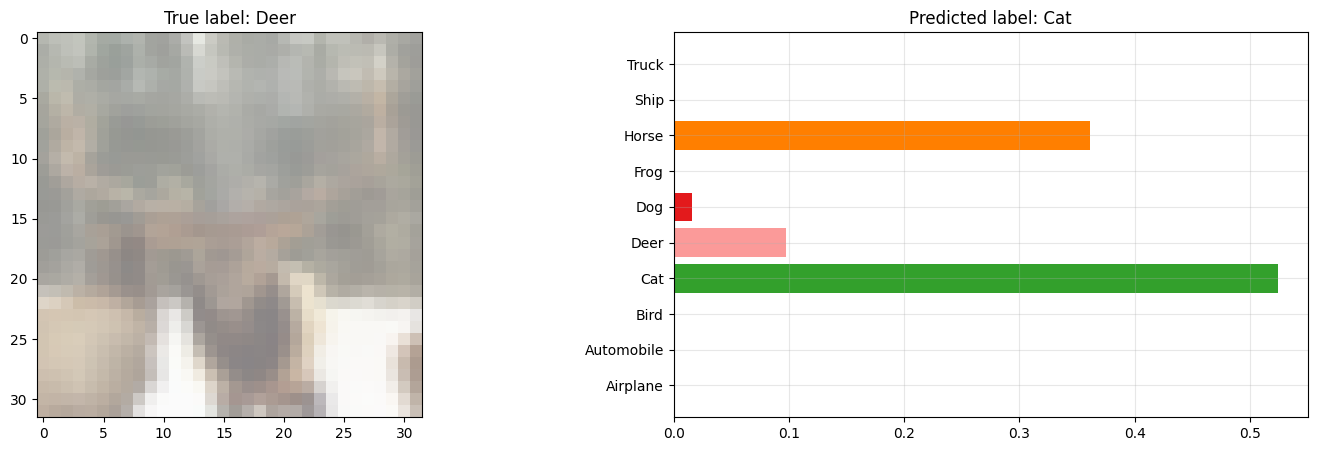

In [ ]:
# Load the saved LeNet model
model = tfk.models.load_model('QuasiVGG9_CIFAR10')

# Choose a random image for visualization
image = np.random.randint(0, num_images)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow((X_test[image] + 1) / 2)
ax1.set_title('True label: ' + labels[np.argmax(y_test[image])])
prediction = model.predict(np.expand_dims(X_test[image], axis=0), verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (10000, 10)


Accuracy: 0.7883
Precision: 0.7874
Recall: 0.7883
F1: 0.7866


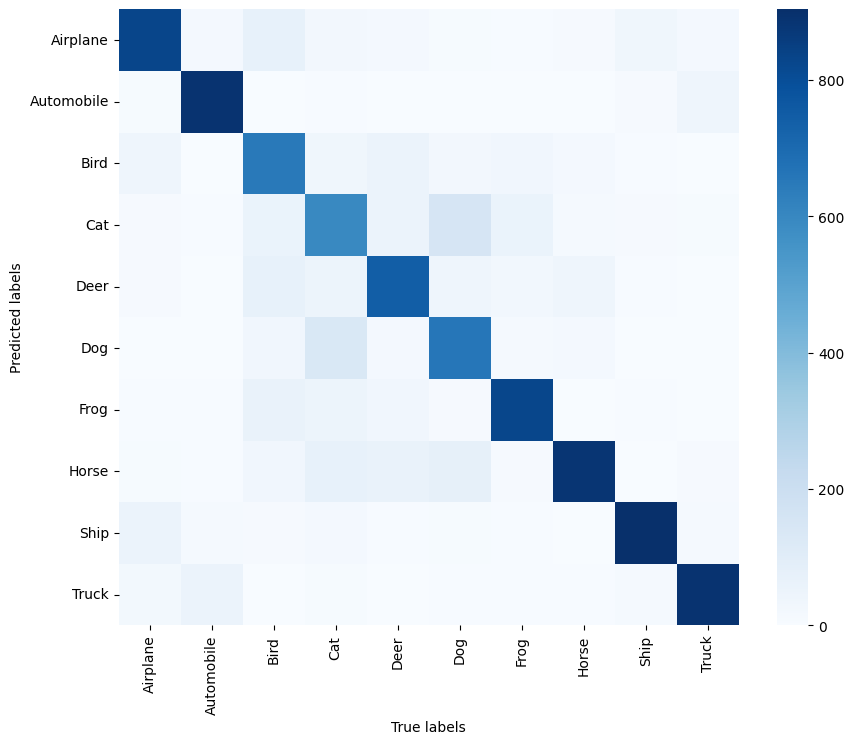

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## TODO Exercise
Perform the same classification analysis on the MNIST and CIFAR10 datasets by increasing the depth of the LeNet and quasiVGG9 networks by one and two convolutional and pooling blocks, exactly as shown in the code.

If you notice overfitting, try to apply the set of techniques shown during the past exercise session.

Note: the number of filters is arbitrary, but typically we tend to increase them as the layer is closer to the output of the network

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*